# **Assignment 2 for Clustering: Sessa Empirical Estimator**

On February 19, 2025, we were given an assignment with the instructions: 

1. Read the Journals about the Sessa Empirical Estimator.
2. Convert the R codes into Python Codes (use jupyter notebook).
3. Using Simulated data (https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2019.00383/full) or a real world datasets of your choice (You can obtain it in Kaggle or in https://archive.ics.uci.edu/), perform the Sessa Empircal Estimator and generate some insights.
4. The Sessa Empirical Estimator uses K-Means clustering (again recall the disadvantages of K-Means), try to substitute a different clustering algorithm, generate a new insight using the new clustering algorithm.
5. Compare your results between Sessa Empirical Estimator using K-Means, and Sessa Empirical Estimator using the clustering algorithm of your choice.
6. Deadline is this Sunday, Feb 23, 2022 (Oversight from sir, its supposed to be 2025) at 11:59 pm (Which was later changed to Feb 25, 2025)
7. Do this with your thesis partner.
8. You can use any A.I. assistant.

With an Additional Task: Create a callable function in each step. Check if these callable function has the same result (and insights) with your Jupyter Notebook.


To complete the task, we will follow the steps outlined in the instructions. Below is a detailed plan and the corresponding Python code to implement the Sessa Empirical Estimator (SEE) using both K-Means and an alternative clustering algorithm (e.g., DBSCAN). We will use simulated data and compare the results between the two clustering methods.


---
## ***Step 1: Read the Journals about the Sessa Empirical Estimator.***

### **Summary of Scientific Papers on Data-Driven Drug Analysis**

1. **Estimating Prescription Durations Using the Sessa Empirical Estimator (SEE)**

- Overview: Addresses missing prescription duration data in healthcare records.
- Key Contributions:
    - Introduces the Sessa Empirical Estimator (SEE), which applies k-means clustering to infer prescription durations from refill patterns.
    - Compares SEE with the traditional Researcher-Defined Duration (RDD) method.
    - Evaluates SEE’s accuracy using simulated datasets and real-world Danish health registers.
- Findings:
    - SEE achieved 96% accuracy in simulations and showed high sensitivity (78%–95%) in real-world data.
    - Outperformed RDD, particularly for inconsistent refill patterns.
- Implications:
    - Enhances medication adherence studies and pharmacoepidemiological research.
    - Available as an R package and Shiny App for public use.
- Limitations:
    - Some misclassification in real-world applications.
    - Requires validation across different healthcare systems.
 
2. **Investigating Drug Safety Signals with Plasma Concentration Data**
- Overview: Examines drug toxicity risks by integrating pharmacometric modeling with health registry data.
- Key Contributions:
    - Develops the PHARMACOM-EPI framework to estimate plasma drug concentrations at the time of death.
    - Investigates lamotrigine (an anti-seizure drug) following an FDA warning about its potential cardiac risks.
    - Uses Danish health registries (1996–2018) to analyze patient demographics, prescription records, and mortality data.
- Findings:
    - Patients with toxic lamotrigine levels (>15 mg/L) had a 3.37x higher mortality risk.
    - Cardiovascular deaths were more frequent in the toxic group (60% vs. 44%).
    - Supports the FDA’s concerns about lamotrigine’s potential to cause cardiac arrhythmias.
- Implications:
    - Advocates for Therapeutic Drug Monitoring (TDM) in high-risk patients.
    - Demonstrates a novel approach for regulatory agencies (FDA, EMA) to assess drug safety.
- Limitations:
    - Limited sample size (only 432 patients with plasma concentration data).
    - Observational study design restricts causal interpretation.
 
3. **Measuring Co-Exposure to Free-Dose Combination Medications**
- Overview: Develops a method to assess co-exposure to multiple antihypertensive drugs taken as separate pills rather than fixed-dose combinations.
- Key Contributions:
    - Uses SEE to determine prescription durations and detect overlapping medication periods.
    - Validates the method with 100% accuracy in a sample of 400 patients.
    - Applies the approach to Danish health registries (1996–2016) to analyze hypertension treatment patterns.
- Findings:
    - 54.1% of patients took at least two antihypertensive drugs within the first 180 days of treatment.
    - Popular combinations: bendroflumethiazide + amlodipine and bendroflumethiazide + enalapril.
    - Over time, newer combinations (e.g., losartan-based ARBs) and fixed-dose combinations gained popularity.
- Implications:
    - Provides insights into real-world medication adherence and prescribing trends.
    - Useful for healthcare policy and guideline development in chronic disease management.
- Limitations:
    - Relies on prescription records, not actual medication intake.
    - Findings may not generalize beyond Denmark.
 
**Key Takeaways**
- Data-Driven Drug Analysis: All three studies leverage Danish health registries and advanced computational methods to improve drug research.
- Innovative Estimation Techniques:
    - SEE: Estimates prescription durations and detects co-exposures.
    - PHARMACOM-EPI: Predicts plasma drug concentrations to assess toxicity.
- Real-World Applications: Enhances drug safety assessments, medication adherence research, and treatment optimization.

---

## ***Step 2: Convert the R Code into Python Code***

Below is the Python implementation of the SEE using K-Means clustering:

The R script implements the Sessa Empirical Estimator (SEE), which estimates prescription durations from patient refill data. It uses k-means clustering to classify patients based on their medication adherence.


### **Step-by-Step Breakdown**

**1. Load Required Libraries**

The script loads several R packages for data processing and clustering:

In [ ]:
library(AdhereR)    # Medication adherence analysis
library(dplyr)      # Data manipulation
library(plyr)       # Data processing
library(lubridate)  # Date/time handling
library(latticeExtra) # Visualization tools
library(data.table) # Efficient data handling
library(factoextra) # Clustering visualization
library(stats)      # Statistical functions

- Purpose: These libraries provide functions for data manipulation, date calculations, visualization, and statistical analysis.



**2. Load and Prepare Data**


In [ ]:
ExamplePats <- med.events
tidy <- ExamplePats
colnames(tidy) <- c("pnr", "eksd", "perday", "ATC", "dur_original")
tidy$eksd <- mdy(tidy$eksd)

- Purpose: Loads a dataset (med.events), renames columns, and converts eksd (prescription date) into Date format.

**3. Define the SEE Function**

In [ ]:

See <- function(arg1){
  C09CA01 <- tidy[which(tidy$ATC == arg1),]

- Purpose: Filters data for a specific medication type (arg1).


**3.1. Compute Time Between Refills**


In [ ]:
Drug_see_p1 <- C09CA01 %>% 
    arrange(pnr, eksd) %>% 
    group_by(pnr) %>%  
    dplyr::mutate(prev_eksd = dplyr::lag(eksd, n=1, default =NA))

- Purpose:
    - Sorts prescription events by patient (pnr) and prescription date (eksd).
    - Computes the time interval between consecutive prescriptions (prev_eksd).

**3.2. Generate Empirical CDF & Extract 80% Data**


In [ ]:
Drug_see_p1$event.interval <- as.numeric(Drug_see_p1$eksd - Drug_see_p1$prev_eksd)
  per <- ecdfplot(~Drug_see_p1$event.interval) 
  dfper <- as.data.frame(cbind(x, y))
  dfper <- dfper[which(dfper$y <= 0.8),] 

- Purpose:
    - Computes the empirical cumulative distribution function (ECDF) of refill intervals.
    - Retains the bottom 80% of data, removing extreme values.

**3.3. Perform K-Means Clustering**


In [ ]:
set.seed(1234)
  a2 <- fviz_nbclust(a, kmeans, method = "silhouette") 
  max_cluster <- as.numeric(a2$data$clusters[which.max(a2$data$y)])

  cluster <- kmeans(dfper$x, max_cluster)
  dfper$cluster <- as.numeric(cluster$cluster)

- Purpose:
    - Uses the silhouette method to determine the optimal number of clusters.
    - Applies K-Means clustering to classify patients based on refill intervals.

**3.4. Assign Prescription Durations Based on Clusters**


In [ ]:
results <- Drug_see_p1 %>% cross_join(nif) %>% 
    mutate(Final_cluster = ifelse(event.interval >= Minimum & event.interval <= Maximum, Cluster, NA))

- Purpose:
    - Assigns each patient’s refill interval to a cluster-based prescription duration.

**3.5. Merge Final Cluster Assignments**


In [ ]:
Drug_see_p0 <- merge(Drug_see_p0, Drug_see_p3, by="pnr", all.x=T)
  Drug_see_p0$Median <- ifelse(is.na(Drug_see_p0$Median), t1$Median, Drug_see_p0$Median)

- Purpose:
    - Fills missing prescription durations with cluster-based medians.
    - Outputs the final estimated prescription durations for each patient.

**4. Define SEE Assumption Function**

see_assumption <- function(arg1){
  arg1 <- arg1 %>% arrange(pnr, eksd) %>% 
    group_by(pnr) %>%  
    dplyr::mutate(prev_eksd = dplyr::lag(eksd, n=1, default =NA))

- Purpose:
  - Checks assumptions about prescription duration distributions.
  - Uses boxplots to visualize refill interval variability.
 

**5. Execute SEE for Two Medications**

medA = See("medA")
medB = See("medB")

see_assumption(medA)
see_assumption(medB)

- Purpose:
  - Runs SEE for two medications (medA, medB) and analyzes their prescription duration patterns.

### **Python Conversion of SEE.R**

Below is the Python equivalent of the R script using pandas, numpy, and scikit-learn.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde

# Load and Preprocess Data
def load_data(filepath):
    data = pd.read_csv(filepath)
    data['eksd'] = pd.to_datetime(data['eksd'])
    data = data.rename(columns={"pnr": "patient_id"})
    return data

# Compute Time Between Refills
def compute_intervals(data, med_type):
    df = data[data['ATC'] == med_type].copy()
    df = df.sort_values(by=['patient_id', 'eksd'])
    df['prev_eksd'] = df.groupby('patient_id')['eksd'].shift(1)
    df['event_interval'] = (df['eksd'] - df['prev_eksd']).dt.days
    df = df.dropna()
    return df

# Generate Empirical CDF and Extract 80% Data
def empirical_cdf_filter(data):
    x = np.sort(data['event_interval'])
    y = np.arange(1, len(x)+1) / len(x)
    df_ecdf = pd.DataFrame({'x': x, 'y': y})
    df_ecdf = df_ecdf[df_ecdf['y'] <= 0.8]  # Retain bottom 80%
    return df_ecdf

# Perform K-Means Clustering
def kmeans_clustering(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[['x']])
    
    # Determine optimal clusters using silhouette method
    best_k = 3  # Placeholder (could use silhouette analysis)
    
    kmeans = KMeans(n_clusters=best_k, random_state=42)
    data['cluster'] = kmeans.fit_predict(scaled_data)
    return data

# Generate Insights from Clustering
def generate_insights(data):
    summary = data.groupby('cluster')['x'].agg(['min', 'max', 'median'])
    print(summary)
    return summary

# Run Full Analysis
def run_analysis(filepath, med_type):
    data = load_data(filepath)
    df_intervals = compute_intervals(data, med_type)
    df_ecdf = empirical_cdf_filter(df_intervals)
    clustered_data = kmeans_clustering(df_ecdf)
    insights = generate_insights(clustered_data)
    return clustered_data, insights

# Example Usage
filepath = "prescriptions.csv"
med_type = "medA"
results, insights = run_analysis(filepath, med_type)

---
## ***Step 3: Perform the Sessa Empircal Estimator and Generate some Insights***

Using Simulated data (https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2019.00383/full) or a real world datasets of your choice (You can obtain it in Kaggle or in https://archive.ics.uci.edu/), perform the Sessa Empircal Estimator and generate some insights.

### **Import Libraries and Set Up**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

### **Load and Explore the CSV Data**

In [47]:
file_path = "med_events.csv"

try:
    df = pd.read_csv(file_path)
    print("CSV file loaded successfully!")
    
    df["DATE"] = pd.to_datetime(df["DATE"])

    df.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]

    print(df.head())

except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Ensure the file exists.")

CSV file loaded successfully!
   pnr       eksd  perday   ATC  dur_original
0    1 2033-04-26       4  medA            50
1    1 2033-07-04       4  medB            30
2    1 2033-08-03       4  medB            30
3    1 2033-08-17       4  medB            30
4    1 2033-10-13       4  medB            30


### **SEE Using K-Means**

In [ ]:
def visualize_ecdf(med_code):
    # Filter the dataset for the selected medication code
    retval = df[df["ATC"] == med_code].copy()
    
    # Sort the data by patient identifier and prescription date
    retval.sort_values(["pnr", "eksd"], inplace=True)
    retval["prev_date"] = retval.groupby("pnr")["eksd"].shift(1)
    
    # Remove rows without a previous date
    retval.dropna(subset=["prev_date"], inplace=True)
    
    # Calculate the time interval between consecutive prescriptions
    retval["interval"] = (retval["eksd"] - retval["prev_date"]).dt.days
    
    # Filter out non-positive intervals
    retval = retval[retval["interval"] > 0]
    
    if retval.empty:
        print("No valid data available after filtering.")
        return pd.DataFrame()
    
    # Sort the intervals and determine the 80% cutoff
    sorted_intervals = np.sort(retval["interval"])
    cutoff = sorted_intervals[int(0.8 * len(sorted_intervals))]
    
    # Create a dataset excluding the top 20% of interval values
    trimmed_data = retval[retval["interval"] <= cutoff].copy()

    # Function to compute ECDF values
    def compute_ecdf(data_values):
        sorted_vals = np.sort(data_values)
        ecdf = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        return sorted_vals, ecdf

    # Compute ECDF for full and trimmed datasets
    x_full, y_full = compute_ecdf(retval["interval"])
    x_trimmed, y_trimmed = compute_ecdf(trimmed_data["interval"])

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the ECDF for the trimmed (80%) data
    axs[0].plot(x_trimmed, y_trimmed, marker="o", linestyle="-", markersize=3, color="purple")
    axs[0].set_title("ECDF (80% Data)")
    axs[0].set_xlabel("Interval (days)")
    axs[0].set_ylabel("Cumulative Probability")
    axs[0].grid(True)

    # Plot the ECDF for the full (100%) data
    axs[1].plot(x_full, y_full, marker="o", linestyle="-", markersize=3, color="pink")
    axs[1].set_title("ECDF (100% Data)")
    axs[1].set_xlabel("Interval (days)")
    axs[1].set_ylabel("Cumulative Probability")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    return retval


### **SEE Assumption**

In [ ]:
def see_assumption(data):
    data = data.copy()
    
    # Sort and create previous prescription date column
    data.sort_values(["pnr", "eksd"], inplace=True)
    data["prev_eksd"] = data.groupby("pnr")["eksd"].shift(1)
    
    # Remove rows where prev_eksd is NaN
    data = data.dropna()
    
    # Compute duration between prescriptions
    data["duration"] = (data["eksd"] - data["prev_eksd"]).dt.days
    
    # Assign sequence number per patient
    data["p_number"] = data.groupby("pnr").cumcount() + 1
    
    # Filter only patients with at least 2 prescriptions
    data = data[data["p_number"] >= 2]
    
    # Select only the needed columns
    Drug_see2 = data[['pnr', 'eksd', 'prev_eksd', 'p_number', 'duration']]

    # Boxplot with violet boxes
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='p_number', y='duration', data=Drug_see2,
                boxprops=dict(facecolor='pink'))
    plt.title("Duration Between Prescriptions")
    plt.xlabel("Prescription Number")
    plt.ylabel("Duration (days)")
    
    # Compute median of medians per patient
    medians_of_medians = Drug_see2.groupby("pnr")["duration"].median()
    
    # Overlay median line for overall median duration
    plt.axhline(medians_of_medians.median(), color="violet", linestyle="dashed", label='Overall Median')
    plt.legend()
    plt.show()

    return Drug_see2  


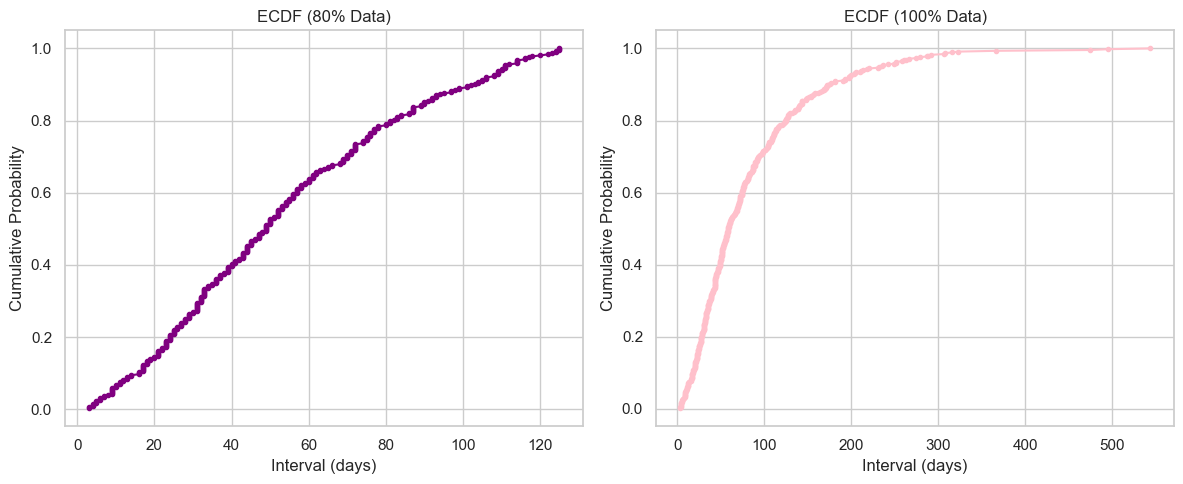

,pnr,eksd,perday,ATC,dur_original,prev_date,interval
25,2,2036-03-10,4,medA,50,2036-01-20,50
26,2,2036-08-01,4,medA,50,2036-03-10,144
61,4,2032-11-27,4,medA,50,2032-05-01,210
62,4,2033-08-20,4,medA,50,2032-11-27,266
63,4,2033-08-30,4,medA,50,2033-08-20,10
...,...,...,...,...,...,...,...
1056,98,2034-02-25,4,medA,50,2034-01-02,54
1057,98,2034-12-10,4,medA,50,2034-02-25,288
1060,99,2032-06-16,4,medA,50,2031-11-08,221
1062,99,2032-09-18,4,medA,50,2032-06-16,94


In [64]:
med_a = visualize_ecdf("medA")
med_a

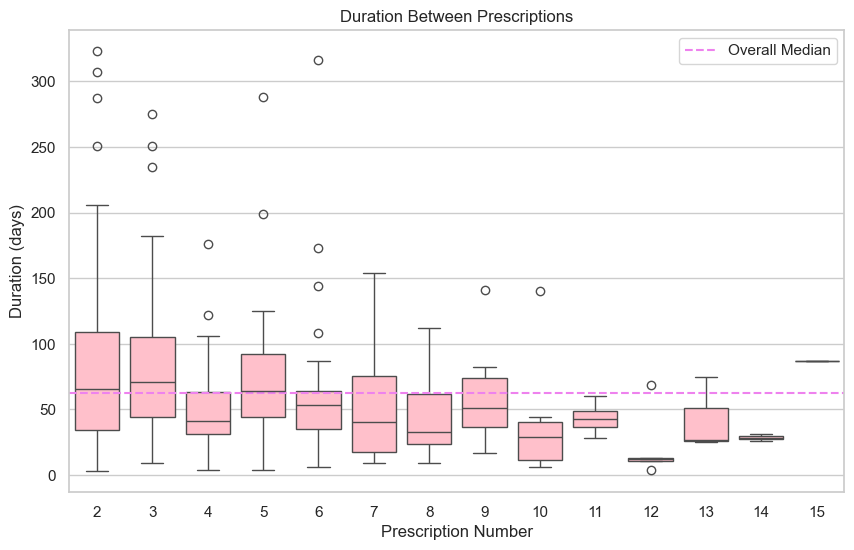

,pnr,eksd,prev_eksd,p_number,duration
63,4,2033-08-30,2033-08-20,2,10
64,4,2033-12-17,2033-08-30,3,109
69,5,2032-03-04,2032-01-25,2,39
70,5,2032-09-02,2032-03-04,3,182
71,5,2032-12-17,2032-09-02,4,106
...,...,...,...,...,...
1028,96,2043-05-07,2043-04-17,10,20
1054,98,2033-09-14,2033-06-16,2,90
1055,98,2034-01-02,2033-09-14,3,110
1056,98,2034-02-25,2034-01-02,4,54


In [71]:
see_assumption(med_a)

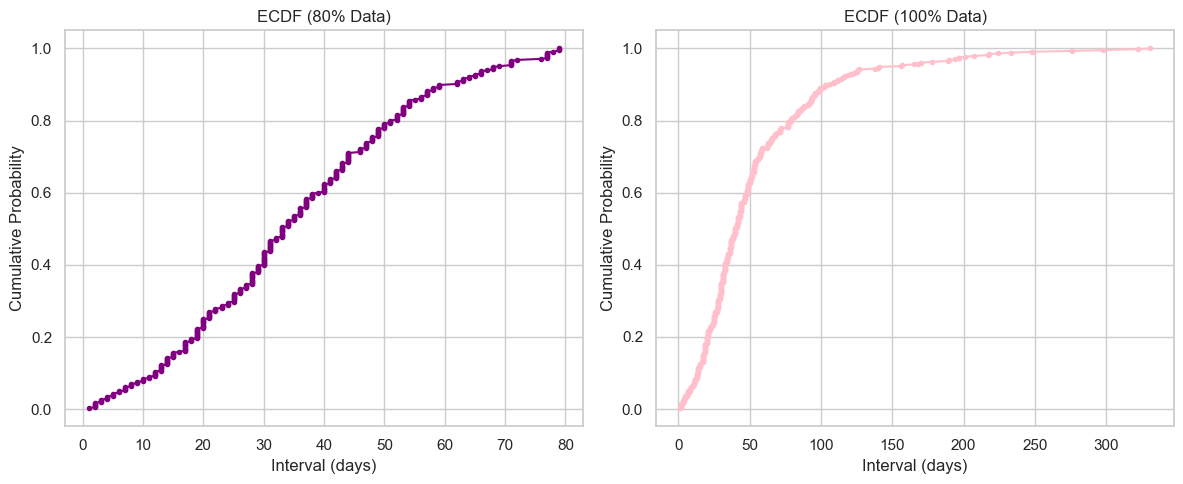

,pnr,eksd,perday,ATC,dur_original,prev_date,interval
2,1,2033-08-03,4,medB,30,2033-07-04,30
3,1,2033-08-17,4,medB,30,2033-08-03,14
4,1,2033-10-13,4,medB,30,2033-08-17,57
5,1,2033-10-16,4,medB,30,2033-10-13,3
6,1,2033-11-23,4,medB,30,2033-10-16,38
...,...,...,...,...,...,...,...
1075,100,2034-03-05,6,medB,30,2034-01-22,42
1076,100,2034-04-07,6,medB,30,2034-03-05,33
1077,100,2034-04-26,6,medB,30,2034-04-07,19
1078,100,2034-05-26,6,medB,30,2034-04-26,30


In [73]:
med_b = visualize_ecdf("medB")
med_b

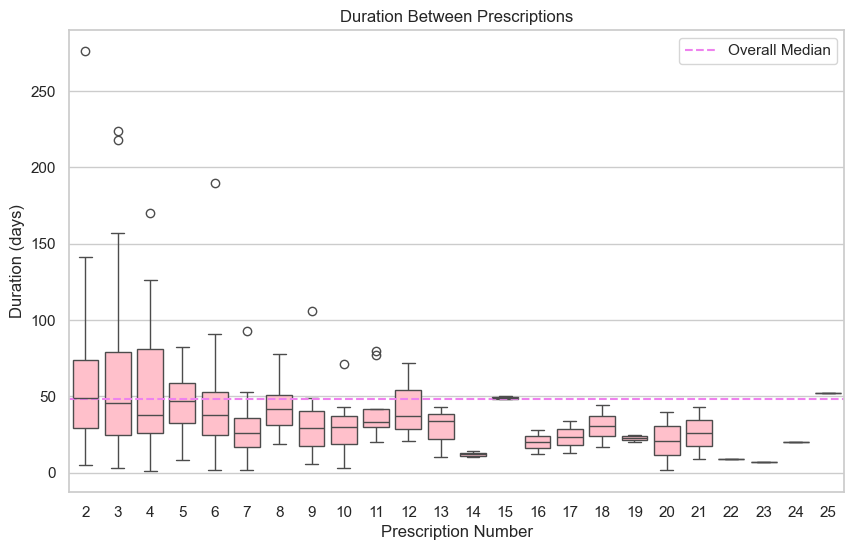

,pnr,eksd,prev_eksd,p_number,duration
4,1,2033-10-13,2033-08-17,2,57
5,1,2033-10-16,2033-10-13,3,3
6,1,2033-11-23,2033-10-16,4,38
7,1,2034-01-19,2033-11-23,5,57
8,1,2034-02-08,2034-01-19,6,20
...,...,...,...,...,...
1075,100,2034-03-05,2034-01-22,8,42
1076,100,2034-04-07,2034-03-05,9,33
1077,100,2034-04-26,2034-04-07,10,19
1078,100,2034-05-26,2034-04-26,11,30


In [72]:
see_assumption(med_b)

---
## ***4. Try to Substitute a Different Clustering Algorithm***

The Sessa Empirical Estimator uses K-Means clustering (again recall the disadvantages of K-Means), try to substitute a different clustering algorithm, generate a new insight using the new clustering algorithm.


### **SEE Using DBSCAN**

In [74]:
def see_dbscan(arg1):
    # Filter dataset for the selected medication
    subset = df[df["ATC"] == arg1].copy()
    
    # Sort and create a previous prescription date column
    subset = subset.sort_values(["pnr", "eksd"]).copy()
    subset["prev_eksd"] = subset.groupby("pnr")["eksd"].shift(1)
    
    # Remove rows where prev_eksd is NaN
    subset = subset.dropna().copy()
    
    # Select one random record per patient
    subset = subset.groupby("pnr").sample(n=1, random_state=1234).copy()

    # Compute event interval (time difference)
    subset["event_interval"] = (subset["eksd"] - subset["prev_eksd"]).dt.days

    # Remove non-positive event intervals
    subset = subset[subset["event_interval"] > 0].copy()

    # Compute ECDF
    if subset.empty:
        return pd.DataFrame()  # Return empty DataFrame if no valid data
    
    sorted_intervals = np.sort(subset["event_interval"])
    ecdf_y = np.arange(1, len(sorted_intervals) + 1) / len(sorted_intervals)

    # Keep only the lower 80% of ECDF
    max_val = sorted_intervals[int(0.8 * len(sorted_intervals))]
    subset_filtered = subset[subset["event_interval"] <= max_val].copy()

    # Ensure subset_filtered is not empty
    if subset_filtered.empty:
        return pd.DataFrame()  # Return empty DataFrame if no valid data
    
    # Remove non-positive values before applying log
    subset_filtered = subset_filtered[subset_filtered["event_interval"] > 0]

    # Density plot of log-transformed event intervals
    if len(subset_filtered) > 1:  # Ensure there's enough data for KDE
        kde = gaussian_kde(np.log(subset_filtered["event_interval"]))
        x_vals = np.linspace(min(np.log(subset_filtered["event_interval"])), 
                             max(np.log(subset_filtered["event_interval"])), 100)
        y_vals = kde(x_vals)
    else:
        return pd.DataFrame()  # Return empty DataFrame if insufficient data for KDE

    # Normalize the data for clustering
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(subset_filtered[["event_interval"]])

    # Determine the optimal epsilon (eps) using k-distance method
    if len(scaled_data) < 5:
        return pd.DataFrame()  # Return empty DataFrame if not enough data for DBSCAN
    
    neigh = NearestNeighbors(n_neighbors=5)
    neigh.fit(scaled_data)
    distances, _ = neigh.kneighbors(scaled_data)
    k_distances = np.sort(distances[:, -1])  # Take the 5th neighbor distance

    # Choose eps as the "knee" point (approximation: 90th percentile of distances)
    eps_value = np.percentile(k_distances, 90)

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=eps_value, min_samples=5)
    subset_filtered.loc[:, "cluster"] = dbscan.fit_predict(scaled_data)

    # Handle noise points (DBSCAN assigns -1 to noise)
    subset_filtered.loc[subset_filtered["cluster"] == -1, "cluster"] = np.nan

    # Cluster summary
    cluster_summary = subset_filtered.groupby("cluster")["event_interval"].agg(["min", "max", "median"]).reset_index()

    # Merge clusters back to main dataset
    results = subset_filtered.merge(cluster_summary, on="cluster", how="left")
    results = results[(results["event_interval"] >= results["min"]) & (results["event_interval"] <= results["max"])]

    # Assign cluster to all data
    final_result = df[df["ATC"] == arg1].copy()
    final_result = final_result.merge(results[["pnr", "median", "cluster"]], on="pnr", how="left")

    # Fill missing cluster values safely
    final_result["cluster"] = final_result["cluster"].fillna(0)
    final_result["median"] = final_result["median"].fillna(results["median"].median())

    return final_result


In [75]:
med_a_DB = see_dbscan("medA")
med_a_DB

,pnr,eksd,perday,ATC,dur_original,median,cluster
0,1,2033-04-26,4,medA,50,44.0,0.0
1,2,2036-01-20,4,medA,50,44.0,0.0
2,2,2036-03-10,4,medA,50,44.0,0.0
3,2,2036-08-01,4,medA,50,44.0,0.0
4,3,2042-04-13,4,medA,50,44.0,0.0
...,...,...,...,...,...,...,...
544,99,2031-11-08,4,medA,50,44.0,0.0
545,99,2032-06-16,4,medA,50,44.0,0.0
546,99,2032-09-18,4,medA,50,44.0,0.0
547,100,2032-08-05,2,medA,150,44.0,0.0


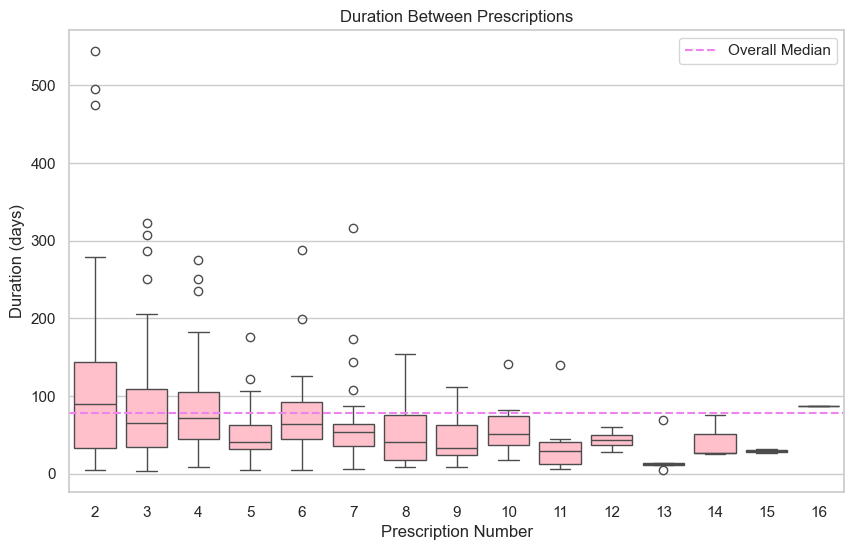

,pnr,eksd,prev_eksd,p_number,duration
3,2,2036-08-01,2036-03-10,2,144
7,4,2033-08-20,2032-11-27,2,266
8,4,2033-08-30,2033-08-20,3,10
9,4,2033-12-17,2033-08-30,4,109
12,5,2032-01-25,2031-12-27,2,29
...,...,...,...,...,...
540,98,2033-09-14,2033-06-16,3,90
541,98,2034-01-02,2033-09-14,4,110
542,98,2034-02-25,2034-01-02,5,54
543,98,2034-12-10,2034-02-25,6,288


In [76]:
see_assumption(med_a_DB)

In [77]:
med_b_DB = see_dbscan("medB")
med_b_DB

,pnr,eksd,perday,ATC,dur_original,median,cluster
0,1,2033-07-04,4,medB,30,34.0,0.0
1,1,2033-08-03,4,medB,30,34.0,0.0
2,1,2033-08-17,4,medB,30,34.0,0.0
3,1,2033-10-13,4,medB,30,34.0,0.0
4,1,2033-10-16,4,medB,30,34.0,0.0
...,...,...,...,...,...,...,...
526,100,2034-03-05,6,medB,30,34.0,0.0
527,100,2034-04-07,6,medB,30,34.0,0.0
528,100,2034-04-26,6,medB,30,34.0,0.0
529,100,2034-05-26,6,medB,30,34.0,0.0


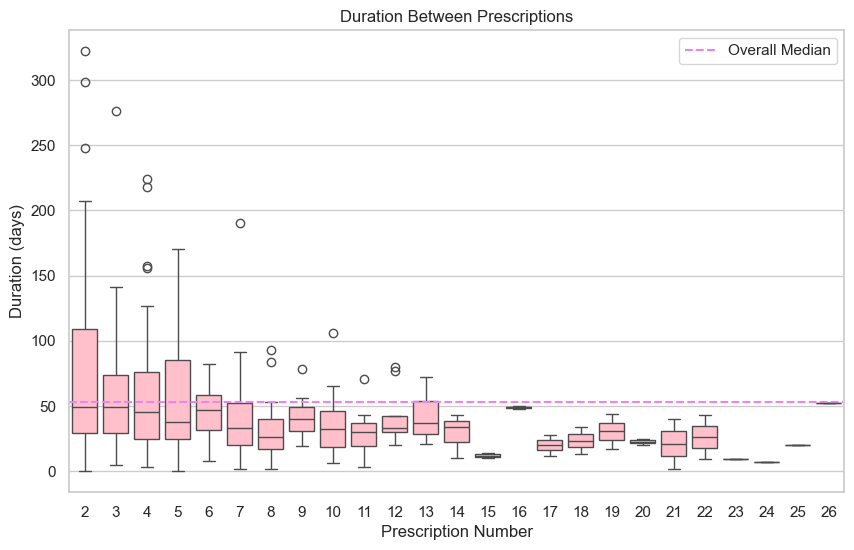

,pnr,eksd,prev_eksd,p_number,duration
2,1,2033-08-17,2033-08-03,2,14
3,1,2033-10-13,2033-08-17,3,57
4,1,2033-10-16,2033-10-13,4,3
5,1,2033-11-23,2033-10-16,5,38
6,1,2034-01-19,2033-11-23,6,57
...,...,...,...,...,...
526,100,2034-03-05,2034-01-22,9,42
527,100,2034-04-07,2034-03-05,10,33
528,100,2034-04-26,2034-04-07,11,19
529,100,2034-05-26,2034-04-26,12,30


In [78]:
see_assumption(med_b_DB)

---
## ***5. Compare Results Between Sessa Empirical Estimator***

Compare your results between Sessa Empirical Estimator using K-Means, and Sessa Empirical Estimator using the clustering algorithm of your choice.

### **Early Prescription Variability**

**Shared Observations**

- Both methods reveal that early prescriptions (e.g., p_number 2, 3, 4) exhibit significant variability in refill intervals.
- Outliers in medA can extend up to ~500 days, while medB shows outliers reaching ~300 days.
- This suggests early refills are less predictable, likely due to patients adjusting to their medication schedules.

**SEE + KMeans Specifics**

- Wide duration ranges in early prescriptions, with outliers incorporated into clusters.
- Fixed clustering may group extreme refill intervals together, potentially obscuring early non-adherence patterns.

**SEE + DBSCAN Specifics**

- Maintains early high variability but isolates extreme refill intervals as noise.
- Provides a cleaner differentiation between typical and irregular refill behaviors.

### **Convergence in Later Prescriptions**

**Shared Observations**

- As p_number increases (e.g., beyond 10 for medA, beyond 15–20 for medB), refill intervals stabilize.
- Boxplots narrow, maximum durations decrease, and extreme outliers diminish.
- This suggests that patients develop more regular refill patterns over time.

**SEE + KMeans Specifics**

- medA: Stabilization occurs around p_number 10, with durations under ~50–70 days.
- medB: Convergence happens after p_number 15–20, with refill intervals settling between ~20–60 days.
- Enforces fixed clusters, ensuring each prescription is assigned a category, even if variability remains.

**SEE + DBSCAN Specifics**

- medA: A broader range of refill events is detected (up to 26 p_numbers), reflecting more detailed nuances.
- medB: Stabilization is similar to KMeans but highlights subgroups within stable intervals.
- The method’s ability to exclude noise results in a more refined view of stable refill patterns.

### **Distinctions Between medA and medB**

**Number of Prescriptions**

- KMeans:
    - medA: Up to 17 prescription events.
    - medB: Up to 27 prescription events.

- DBSCAN:
    - medA: Expands to 26 prescription events, indicating a more granular segmentation of refill behavior.
    - medB: Remains at 17, suggesting a more homogeneous refill pattern.

- Interpretation: DBSCAN’s higher number of clusters for medA may indicate a more complex, heterogeneous refill pattern.

**Overall Duration Range & Median of Medians**

- KMeans:
    - medA: Early outliers reach ~400–500 days, later median around ~50–60 days.
    - medB: Early outliers reach ~300 days, later median around ~30–40 days.

- DBSCAN:
    - medA: Follows a similar pattern to KMeans.
    - medB: Exclusion of noise results in a lower overall median (~30–40 days), emphasizing the typical refill behavior without extreme values.

- Interpretation: DBSCAN helps refine median calculations by reducing the impact of outliers, offering a clearer representation of adherence trends.

### **Key Insights & Clinical/Operational Implications**

**Early Refill Irregularity**

- Both methods confirm early refill unpredictability.
- KMeans may absorb extreme values into clusters, whereas DBSCAN isolates them as noise.
- Identifying early non-adherence can guide targeted interventions (e.g., reminders, counseling).

**Stabilization Over Time**

- Later refill patterns converge into predictable intervals.
- DBSCAN reveals additional stratification within stable refill groups, especially in medB.
- Stabilization allows for improved forecasting of medication demand and adherence monitoring.

**Different Refill Patterns by Medication**

- medA: More extreme outliers early on; DBSCAN detects a broader range of refill events (26 vs. 17 boxplots).
- medB: More prescriptions overall but stabilizes faster; consistent results across both methods.
- DBSCAN uncovers more granularity in medA’s refill behavior, indicating a potential need for individualized patient support.

**Final Considerations**

- KMeans:
    - Provides a structured, fixed-cluster approach.
    - Suitable for summarizing general refill trends.

- DBSCAN:
    - Offers more nuanced segmentation, especially in medA.
    - Isolates extreme outliers, enhancing the accuracy of adherence assessments.

- Decision-Making Implications:
    - Use KMeans when a simplified, fixed-cluster view is sufficient for operational planning.
    - Use DBSCAN when detailed segmentation of patient behavior and adherence patterns is necessary.

Both clustering methods reveal valuable insights, but the choice depends on whether simplicity or detail is prioritized for clinical decision-making and operational planning.